In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.0
Running on TPU  ['10.13.151.250:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.13.151.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.151.250:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# **Import Required Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
from copy import copy, deepcopy
import pytz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from pickle import dump, load

from matplotlib.dates import num2date
from matplotlib.ticker import Formatter
from datetime import datetime
from pathlib import Path

from tensorflow import GradientTape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import RootMeanSquaredError, Mean
from tensorflow.keras.layers import Input, Dense, LSTM, Layer, Bidirectional, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import huber, mse, Loss, Reduction
import tensorflow.keras.backend as K

# **Import Data**

In [4]:
scaler = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/scaler.pkl', 'rb'))
officeTS = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/officeTS.pkl', 'rb'))

trainSplit = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/trainSplit.pkl', 'rb'))
testSplit = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/testSplit.pkl', 'rb'))
dateTrainSplit = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTrainSplit.pkl', 'rb'))
dateTestSplit = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTestSplit.pkl', 'rb'))

In [5]:
# Perform Standardization
trainScaled = np.transpose(scaler.transform(np.transpose(trainSplit)))
testScaled = np.transpose(scaler.transform(np.transpose(testSplit)))

print(trainScaled.shape)
print(testScaled.shape)

(11, 46760)
(11, 11704)


# **Utility Functions**

In [6]:
# Make Windows
def makeWindowsFromContinuousSteps(officesData, dateData, history, leadSteps):
    '''
    officesData     : 2-D Numpy Array (number of offices, total number of readings)
    dateData        : 2-D Numpy Array (number of offices, total number of readings)
    history         : Number of TIMESTEPS to be considered as Input to Forecasting Model
    leadSteps       : Number of TIMESTEPS to be considered as Output to Forecasting Model
    '''
    dataX, dataY, officeNumber = [], [], []
    dateX, dateY = [], []
    idxWindows = []

    # If only 1 office data is present, i.e. shape of officesData is
    # (total number of readings,), then reshape to (1, total number of readings)
    if len(officesData.shape)==1:
        officesData = officesData.reshape(1,-1)
    elif not len(officesData.shape)==2:
        raise('Unacceptable input shape of officesData variable - ' + str(officesData.shape))
    
    # If only 1 date data is present, i.e. shape of dateData is
    # (total number of readings,), then reshape to (1, total number of readings)
    if len(dateData.shape)==1:
        dateData = dateData.reshape(1,-1)
    elif not len(dateData.shape)==2:
        raise('Unacceptable input shape of dateData variable - ' + str(dateData.shape))

    for i in range(officesData.shape[0]):
        continuousSubSequenceStartIndex = 0
        continuousSubSequenceStopIndex  = 0
        searchingForNAN = True
        seqCounter = 0
        while seqCounter<len(officesData[i]):
            if seqCounter==len(officesData[i])-1:
                if np.isnan(officesData[i, seqCounter]):
                    continuousSubSequenceStopIndex = seqCounter - 1
                else:
                    continuousSubSequenceStopIndex = seqCounter
                ### Perform continuousSubSequence Operation - Extract Windows ###
                if continuousSubSequenceStopIndex - continuousSubSequenceStartIndex + 1 >= history + leadSteps:
                    for k in range(continuousSubSequenceStartIndex, continuousSubSequenceStopIndex+1):
                        if k + history + leadSteps <= continuousSubSequenceStopIndex + 1:
                            dataX.append(officesData[i, k:k+history])
                            dataY.append(officesData[i, k+history:k+history+leadSteps])
                            officeNumber.append(i)
                            dateX.append(dateData[i, k:k+history])
                            dateY.append(dateData[i, k+history:k+history+leadSteps])
                            idxWindows.append((i, k))
                break
            if not np.isnan(officesData[i, seqCounter]):
                if not searchingForNAN:
                    searchingForNAN = True
                    continuousSubSequenceStartIndex = seqCounter
            else:
                if searchingForNAN:
                    searchingForNAN = False
                    continuousSubSequenceStopIndex = seqCounter - 1
                    ### Perform continuousSubSequence Operation - Extract Windows ###
                    if continuousSubSequenceStopIndex - continuousSubSequenceStartIndex + 1 >= history + leadSteps:
                        for k in range(continuousSubSequenceStartIndex, continuousSubSequenceStopIndex+1):
                            if k + history + leadSteps <= continuousSubSequenceStopIndex + 1:
                                dataX.append(officesData[i, k:k+history])
                                dataY.append(officesData[i, k+history:k+history+leadSteps])
                                officeNumber.append(i)
                                dateX.append(dateData[i, k:k+history])
                                dateY.append(dateData[i, k+history:k+history+leadSteps])
                                idxWindows.append((i, k))
            seqCounter += 1
    return dataX, dataY, officeNumber, dateX, dateY, idxWindows

In [7]:
def calcInvScaledError(scaledPrediction, scaledTruth, errorMetric='RMSE', scaler=None, dataToScalerIndices=None):
    if scaler is not None:
        if dataToScalerIndices is None:
            if len(scaler.mean_) > 1:
                raise("Different scaler used for different datapoints but back reference is not provided - dataToScalerIndices is None!")
            else:
                inv_scaledPrediction = np.transpose(scaler.inverse_transform(np.transpose(scaledPrediction)))
                inv_scaledTruth = np.transpose(scaler.inverse_transform(np.transpose(scaledTruth)))
        else:
            inv_scaledPrediction = deepcopy(scaledPrediction)
            inv_scaledTruth = deepcopy(scaledTruth)
            for i in range(len(scaledPrediction)):
                inv_scaledPrediction[i,:] = (scaledPrediction[i,:]*(scaler.mean_[dataToScalerIndices[i]]))+np.sqrt(scaler.var_[dataToScalerIndices[i]])
                inv_scaledTruth[i,:] = (scaledTruth[i,:]*(scaler.mean_[dataToScalerIndices[i]]))+np.sqrt(scaler.var_[dataToScalerIndices[i]])
        prediction = inv_scaledPrediction
        truth = inv_scaledTruth
    else:
        prediction = scaledPrediction
        truth = scaledTruth
    if errorMetric=='RMSE':
        error = mean_squared_error(truth, prediction, squared=False)
    elif errorMetric=='MSE':
        error = mean_squared_error(truth, prediction, squared=True)
    else:
        raise('Unsupported error metric - ' + errorMetric)
    return error

In [8]:
# Inverse Transform the Standardization Process
def invertStandardization(scaler, data, officeNumber):
    '''
    # Params::
    scaler          : sklearn StandardScaler object which was used to perform standardization
    data            : ndarray of shape (number of windows, time-steps)
    officeNumber    : ndarray of shape (number of windows) - specifying the office number to which a window belongs

    # Returns::
    data_tr         : ndarray of shape (number of windows, time-steps)
    '''
    mean = scaler.mean_
    std  = np.sqrt(scaler.var_)
    data_tr = np.zeros((data.shape))
    for i in range(data.shape[0]):
        data_tr[i,:] = (data[i,:]*std[officeNumber[i]]) + mean[officeNumber[i]]
    return data_tr

# **Main Code Starts Here**

In [9]:
# Selected Working Hours: start_time - end_time (MON-FRI)
start_time = 5
end_time = 19

# Calculate total number of days and readings per day
readingsPerDay = (end_time-start_time)*4
totalDays = int(officeTS.shape[1]/readingsPerDay)
print('Readings Per Day = ', readingsPerDay)
print('Total Number of Days = ', totalDays)

# History and Lead Time
historySteps = 5*readingsPerDay #== 5 Days
leadSteps = 1*readingsPerDay #== 1 Day

Readings Per Day =  56
Total Number of Days =  1044


In [29]:
officeIDX = 4

trainX, trainY, officeNumberTrain, dateTrainX, dateTrainY, idxWindows = makeWindowsFromContinuousSteps(trainScaled[officeIDX], dateTrainSplit[officeIDX], historySteps, leadSteps)
print(len(trainX), len(trainY), len(officeNumberTrain), officeNumberTrain[0])
print(trainX[0].shape, trainY[0].shape)
testX, testY, officeNumberTest, dateTestX, dateTestY, idxWindows = makeWindowsFromContinuousSteps(testScaled[officeIDX], dateTestSplit[officeIDX], historySteps, leadSteps)
print(len(testX), len(testY), len(officeNumberTest), officeNumberTest[0])
print(testX[0].shape, testY[0].shape)

46425 46425 46425 0
(280,) (56,)
10640 10640 10640 0
(280,) (56,)


**Prepare imported data for LSTM training**

In [30]:
myTrainX = np.array(trainX)
myTrainY = np.array(trainY)
myTestX = np.array(testX)
myTestY = np.array(testY)
print("Before Reshaping")
print(myTrainX.shape, myTrainY.shape)
print(myTestX.shape, myTestY.shape)

# Reshape Input to be [Samples, Time-Steps, Features]
myTrainX = np.reshape(myTrainX, (myTrainX.shape[0], myTrainX.shape[1], 1))
myTestX = np.reshape(myTestX, (myTestX.shape[0], myTestX.shape[1], 1))
print("After Reshaping")
print(myTrainX.shape, myTrainY.shape)
print(myTestX.shape, myTestY.shape)

Before Reshaping
(46425, 280) (46425, 56)
(10640, 280) (10640, 56)
After Reshaping
(46425, 280, 1) (46425, 56)
(10640, 280, 1) (10640, 56)


In [31]:
class MyCSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, fname='history.csv'):
        self.fname= Path(fname)
    def on_epoch_end(self, epoch, logs=None):
        df = pd.DataFrame([[epoch, logs['loss'], logs['val_loss']]])
        df.to_csv(self.fname, mode='a', header=False, index=False)

In [32]:
model = Sequential()
model.add(Input(shape=(myTrainX.shape[1], myTrainX.shape[2])))
forward_layer1 = LSTM(14, activation='tanh', return_sequences=True)
forward_layer2 = LSTM(14, activation='tanh', return_sequences=False)
backward_layer1 = LSTM(14, activation='tanh', return_sequences=True,
                       go_backwards=True)
backward_layer2 = LSTM(14, activation='tanh', return_sequences=False,
                       go_backwards=True)
model.add(Bidirectional(forward_layer1, backward_layer=backward_layer1))
#model.add(LayerNormalization())
model.add(Bidirectional(forward_layer2, backward_layer=backward_layer2))
#model.add(LayerNormalization())
model.add(Dense(myTrainY.shape[1], activation='linear'))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 40) if (1e-4 * 10**(epoch / 20)<1e-2) else 1e-2)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/weightsBiLSTM_"+str(officeIDX)+".hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)
csv_logger = MyCSVLogger("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/BiLSTMtraining_backup_"+str(officeIDX)+".csv")
es = tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 5e-4 less"
        min_delta=5e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=20,
        verbose=1,
    )
model.compile(loss="huber_loss",
              optimizer=adam,
              metrics=["mean_squared_error"])

model.summary()

batch_size = 500
print("Starting to fit")
#model.load_weights('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/weightsBiLSTM_'+str(officeIDX)+'.hdf5')
history = model.fit(myTrainX, myTrainY, epochs=200, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True, callbacks=[lr_schedule, checkpointer, csv_logger, es])
model.load_weights('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/weightsBiLSTM_'+str(officeIDX)+'.hdf5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 280, 28)          1792      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 28)               4816      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 56)                1624      
                                                                 
Total params: 8,232
Trainable params: 8,232
Non-trainable params: 0
_________________________________________________________________
Starting to fit
Epoch 1/200
 6/84 [=>............................] - ETA: 27s - loss: 0.4160 - mean_squared_error: 0.9677WARNING:tensorflow:Callback method `on_train_batch_end` is slow

84/84 [==============================] - 44s 374ms/step - loss: 0.4048 - mean_squared_error: 0.9425 - val_loss: 0.5325 - val_mean_squared_error: 1.4002 - lr: 1.0000e-04
Epoch 2/200
84/84 [==============================] - 30s 355ms/step - loss: 0.3844 - mean_squared_error: 0.9041 - val_loss: 0.5208 - val_mean_squared_error: 1.3777 - lr: 1.0593e-04
Epoch 3/200
84/84 [==============================] - 30s 358ms/step - loss: 0.3543 - mean_squared_error: 0.8487 - val_loss: 0.5019 - val_mean_squared_error: 1.3304 - lr: 1.1220e-04
Epoch 4/200
84/84 [==============================] - 30s 359ms/step - loss: 0.3257 - mean_squared_error: 0.7852 - val_loss: 0.4763 - val_mean_squared_error: 1.2485 - lr: 1.1885e-04
Epoch 5/200
84/84 [==============================] - 30s 359ms/step - loss: 0.3030 - mean_squared_error: 0.7256 - val_loss: 0.4488 - val_mean_squared_error: 1.1587 - lr: 1.2589e-04
Epoch 6/200
84/84 [==============================] - 30s 358ms/step - loss: 0.2823 - mean_squared_error: 0.

In [ ]:
df = pd.DataFrame(list(zip(history.history['loss'], history.history['val_loss'])),columns =['Training Loss', 'Validation Loss'])
df.to_csv("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/BiLSTMtraining_"+str(officeIDX)+".csv")

In [33]:
#df = pd. read_csv("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/BiLSTMtraining_"+str(officeIDX)+".csv")
df = pd. read_csv("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/models/BiLSTMtraining_backup_"+str(officeIDX)+".csv", header=None)
training_loss = df[1].values #df['Training Loss'].values
val_loss = df[2].values #df['Validation Loss'].values
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.figure(figsize=(10, 6))
plt.rc('font', size=20)         # controls default text sizes
plt.rc('axes', titlesize=22)    # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)   # fontsize of the tick labels
plt.rc('ytick', labelsize=20)  # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=23)  # fontsize of the figure title
plt.plot(epoch_count, training_loss, 'b--', label='Training Loss')
plt.plot(epoch_count, val_loss, 'r--', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/BiLSTMlossCharacteristics_"+str(officeIDX)+".pdf", bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

In [ ]:
# Evaluate Model
print('Training Data Evaluation')
print(model.evaluate(x = myTrainX, y = myTrainY))
print('Test Data Evaluation')
print(model.evaluate(x = myTestX, y = myTestY))

Training Data Evaluation
1451/1451 [==============================] - 46s 31ms/step - loss: 0.0418 - mean_squared_error: 0.0993
[0.0418105311691761, 0.09930828958749771]
Test Data Evaluation
344/344 [==============================] - 11s 33ms/step - loss: 0.1016 - mean_squared_error: 0.2476
[0.10159701853990555, 0.2475760132074356]


In [ ]:
forecast = model.predict(myTrainX)
print(forecast.shape)
print(myTrainX.shape)
print(myTrainY.shape)
naive_forecast = myTrainX[:, -56:, 0]
print(naive_forecast.shape)

print('RMSE for BiLSTM Model = ', mean_squared_error(myTrainY, forecast, squared=False))
print('RMSE for Naive Forecast = ', mean_squared_error(myTrainY, naive_forecast, squared=False))

(46425, 56)
(46425, 280, 1)
(46425, 56)
(46425, 56)
RMSE for BiLSTM Model =  0.3135640680748263
RMSE for Naive Forecast =  0.6099024451129


In [17]:
BiLSTM_forecast = model.predict(myTestX)
print('RMSE for BiLSTM Forecast on Test Set = ', calcInvScaledError(np.array(BiLSTM_forecast), np.array(testY),
                                                                    errorMetric='RMSE', scaler=scaler, dataToScalerIndices=[officeIDX]*len(BiLSTM_forecast)))

RMSE for BiLSTM Forecast on Test Set =  27.594746421731056


In [ ]:
# Forecast
window_idx_to_forecast = 10765

# Create Pandas Series for Index Matching while Plotting
completeSeries = pd.Series(np.concatenate((testX[window_idx_to_forecast], testY[window_idx_to_forecast])))
seriesX = completeSeries[:len(testX[window_idx_to_forecast])]
seriesY = completeSeries[len(testX[window_idx_to_forecast]):]

completeDateSeries = pd.Series(np.concatenate((dateTestX[window_idx_to_forecast], dateTestY[window_idx_to_forecast])))
dateSeriesX = completeDateSeries[:len(dateTestX[window_idx_to_forecast])]
dateSeriesY = completeDateSeries[len(dateTestX[window_idx_to_forecast]):]

In [ ]:
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%d-%m-%Y\n%H:%M:%S'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''
        ts = (self.dates[ind] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
        return datetime.utcfromtimestamp(ts).strftime(self.fmt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # This is added back by InteractiveShellApp.init_path()


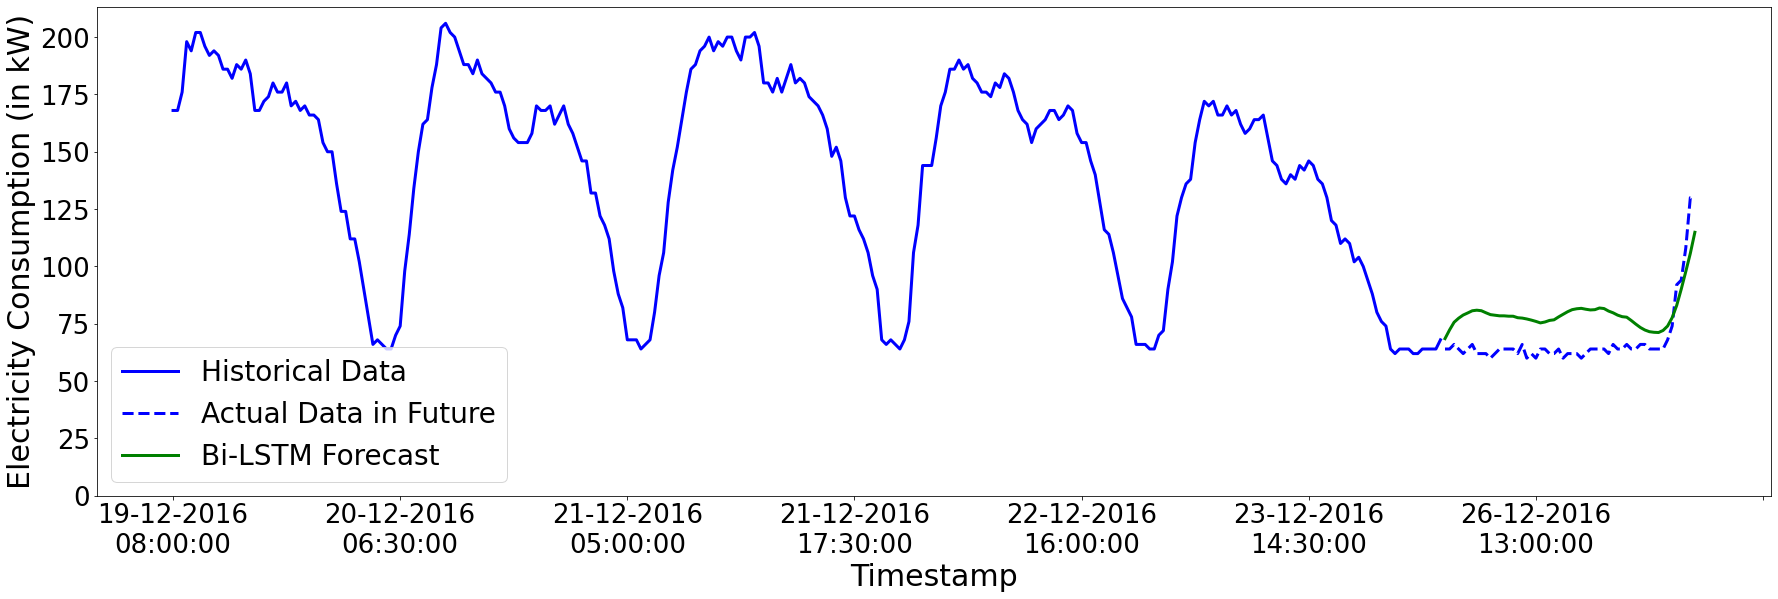

In [ ]:
# Make as pandas series
BiLSTM_forecast_series = pd.Series(BiLSTM_forecast[window_idx_to_forecast], index=dateSeriesY.index)

BiLSTM_forecast_seriesTT = pd.Series(invertStandardization(scaler, np.array([BiLSTM_forecast_series]), np.array([officeIDX]))[0], index=dateSeriesY.index)

seriesXTT = pd.Series(invertStandardization(scaler, np.array([seriesX]), np.array([officeIDX]))[0], index=dateSeriesX.index)
seriesYTT = pd.Series(invertStandardization(scaler, np.array([seriesY]), np.array([officeIDX]))[0], index=dateSeriesY.index)

# Plot
formatter = MyFormatter(np.append(dateTestX[window_idx_to_forecast], dateTestY[window_idx_to_forecast]))
fig, ax = plt.subplots(figsize=(30, 9))
ax.xaxis.set_major_formatter(formatter)
plt.rc('font', size=17)         # controls default text sizes
plt.rc('axes', titlesize=30)    # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=26)   # fontsize of the tick labels
plt.rc('ytick', labelsize=26)   # fontsize of the tick labels
plt.rc('legend', fontsize=28)   # legend fontsize
plt.rc('figure', titlesize=35)  # fontsize of the figure title
plt.plot(seriesXTT, label='Historical Data', color='blue', marker='', linestyle='-', linewidth=3, markersize=2)
plt.plot(seriesYTT, label='Actual Data in Future', color='blue', marker='', linestyle='--', linewidth=3, markersize=2)
plt.plot(BiLSTM_forecast_seriesTT, label='Bi-LSTM Forecast', color='green', marker='', linestyle='-', linewidth=3, markersize=2)
plt.xlabel("Timestamp", fontsize=30)
plt.ylabel("Electricity Consumption (in kW)", fontsize=30)
#plt.title('Forecast vs Actuals')
plt.legend(loc='lower left', fontsize=28)
plt.gca().set_ylim(bottom=0)
plt.show()